# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras/Pytorch. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

In [1]:
# conda env torch_planet
!pip install torch
!pip install torchsummary

In [2]:
import torch
torch.__version__

'1.3.1'

In [3]:
#inspired from https://github.com/pytorch/vision/blob/master/torchvision/models/googlenet.py
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
from torchsummary import summary

In [4]:

GoogLeNetOutputs = namedtuple('GoogLeNetOutputs', ['logits', 'aux_logits2', 'aux_logits1'])
GoogLeNetOutputs.__annotations__ = {'logits': Tensor, 'aux_logits2': Optional[Tensor],
                                    'aux_logits1': Optional[Tensor]}

# _GoogLeNetOutputs set here for backwards compat
_GoogLeNetOutputs = GoogLeNetOutputs

class GoogLeNet(nn.Module):

    def __init__(self, num_classes=1000, aux_logits=True, blocks=None):
        super(GoogLeNet, self).__init__()
        if blocks is None:
            blocks = [BasicConv2d, Inception, InceptionAux]
        assert len(blocks) == 3
        conv_block = blocks[0]
        inception_block = blocks[1]
        inception_aux_block = blocks[2]

        self.aux_logits = aux_logits

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes)
            self.aux2 = inception_aux_block(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _forward(self, x):
        # type: (Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux_defined = self.training and self.aux_logits
        if aux_defined:
            aux1 = self.aux1(x)
        else:
            aux1 = None

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if aux_defined:
            aux2 = self.aux2(x)
        else:
            aux2 = None

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux2, aux1

#     @torch.jit.unused
    def eager_outputs(self, x, aux2, aux1):
        # type: (Tensor, Optional[Tensor], Optional[Tensor]) -> GoogLeNetOutputs
        if self.training and self.aux_logits:
            return _GoogLeNetOutputs(x, aux2, aux1)
        else:
            return x

    def forward(self, x):
        # type: (Tensor) -> GoogLeNetOutputs
        x, aux1, aux2 = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted GoogleNet always returns GoogleNetOutputs Tuple")
            return GoogLeNetOutputs(x, aux2, aux1)
        else:
            return self.eager_outputs(x, aux2, aux1)


class Inception(nn.Module):
    __constants__ = ['branch2', 'branch3', 'branch4']

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj,
                 conv_block=None):
        super(Inception, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def _forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes, conv_block=None):
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = F.dropout(x, 0.7, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)

        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [5]:
model= GoogLeNet()

In [6]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [7]:
import torch
from torch import nn
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Image Encoder
First we fetch a pre-trained convolutional neural network and tweak it slightly so it's not focused on classification anymore. We'll use this to encode our image and then feed that to the caption generator.

In [8]:
class ImageEncoder(nn.Module):
    """Network to encode an image"""
    def __init__(self, out_dim=1000):
        super(ImageEncoder, self).__init__()
        self.resnet = models.resnet152(pretrained=True)
        # it's pretrained, so let's make it not change
        for p in self.resnet.parameters():
            p.requires_grad = False
            
        # the last layer of resnet is Linear that is used for classification
        # we'll change its size, mark it as learnable, and initialize it randomly, since it's not going to be classification anymore
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, out_dim) # constructing it marks it as learnable as well
        assert(all(p.requires_grad for p in self.resnet.fc.parameters()))
        self.resnet.fc.weight.data.normal_(0, 0.02) # weights to a small number
        self.resnet.fc.bias.data.fill_(0) # bias to zero
        
        # TODO: maybe it also makes sense to tweak the one layer before that, that is, the pooling layer
    
    def forward(self, x):
        return self.resnet(x)        

# Caption Generator
This is a recurrent neural network that is first initialized with the encoded image and then starts generating words that will be used as the generated caption. The word embeddings are pretrained.

In [9]:
class PartiallyFixedEmbedding(nn.Module): # from https://discuss.pytorch.org/t/updating-part-of-an-embedding-matrix-only-for-out-of-vocab-words/33297/4
    """
    This embedding has an embedding matrix that is split into two parts: fixed and variable.
    The fixed part is not changed in the learning process, making it ideal for pretrained vocabularies with a few extra words that we want to learn.
    """
    def __init__(self, fixed_weights, num_to_learn):
        super().__init__()
        self.num_fixed = fixed_weights.size(0)
        self.num_to_learn = num_to_learn
        weight = torch.empty(self.num_fixed + num_to_learn, fixed_weights.size(1))
        weight[:self.num_fixed] = fixed_weights
        self.trainable_weight = nn.Parameter(torch.empty(num_to_learn, fixed_weights.size(1)))
        nn.init.kaiming_uniform_(self.trainable_weight)
        weight[self.num_fixed:] = self.trainable_weight
        self.register_buffer('weight', weight)
        
    def forward(self, inp):
        self.weight.detach_()
        self.weight[self.num_fixed:] = self.trainable_weight
        return nn.functional.embedding(inp, self.weight, None, None, 2.0, False, False)

    
class Vocabulary(object):
    START_TOKEN = '<start>'
    END_TOKEN = '<end>'
    PAD_TOKEN = '<pad>'
    CONTROL_WORDS = [START_TOKEN, END_TOKEN, PAD_TOKEN]
    
    def __init__(self, non_control_words):
        self.control_words_count = len(CaptionGenerator.CONTROL_WORDS)
        
        self.vocab = [w for w in non_control_words] + CaptionGenerator.CONTROL_WORDS
        self.non_control_words = self.vocab[:-self.control_words_count]
        self.word2idx = {w: i for (i, w) in enumerate(self.vocab)}
        
    def get_idx(self, word):
        return self.word2idx[word]
    
    def get_start_token_idx(self):
        return self.word2idx[Vocabulary.START_TOKEN]
    
    def get_end_token_idx(self):
        return self.word2idx[Vocabulary.END_TOKEN]
    
    def get_pad_token_idx(self):
        return self.word2idx[Vocabulary.PAD_TOKEN]
    
    def size(self):
        return len(self.vocab)
    
    
class CaptionGenerator(nn.Module):
    CONTROL_WORDS = ['<start>', '<end>', '<pad>']
    
    def __init__(self, vocab, word2vec, encoded_image_size, hidden_size=512, rnn_layers_num=1):
        """
        :param vocab: set of all the words (as strings) in the vocabulary other than CONTROL_WORDS
        :param word2vec: one of the pre-trained models from torchnlp library
        """
        super(CaptionGenerator, self).__init__()
        self.vocab = vocab
        
        self.embed = PartiallyFixedEmbedding(word2vec[vocab.non_control_words], vocab.control_words_count)
        
        self.initial_hidden_state = nn.Linear(encoded_image_size, hidden_size)
        self.initial_cell_state = nn.Linear(encoded_image_size, hidden_size)
        
        self.recurrent_unit = nn.LSTM(word2vec.dim, hidden_size, rnn_layers_num, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab.size())
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        inputs_packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        
        initial_hidden = self.initial_hidden_state(features)
        initial_hidden = initial_hidden.view(-1, initial_hidden.shape[0], initial_hidden.shape[1])
        initial_cell = self.initial_cell_state(features)
        initial_cell = initial_cell.view(-1, initial_cell.shape[0], initial_cell.shape[1])
        
        hiddens, _ = self.recurrent_unit(inputs_packed, (initial_hidden, initial_cell))
        hiddens, _ = pad_packed_sequence(hiddens, batch_first=True)
        outputs = self.linear(hiddens) # maybe a softmax after that?
        return outputs
    
    def to_sentence(self, forward_out, lengths):
        _, tops = forward_out.topk(1)
        tops = tops.view(tops.shape[0], tops.shape[1])
        sentences = []
        for sentence in tops:
            words = []
            for idx in sentence:
                words.append(self.vocab.vocab[idx])
            sentences.append(' '.join(words))
        return sentences

Now let's get some data. We downloaded and unpacked the Flickr8K dataset from http://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b

In [10]:
from torch.utils import data
from os import path
from PIL import Image
from torchvision import transforms

class Flickr8KDataset(data.Dataset):
    def __init__(self, tokens_path, images_path):
        self.img_names_and_captions = []
        self.images_path = images_path
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)), # TODO: maybe add some cropping or sth? this will squash most of the images
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # normalization required by resnet
        ])
        with open(tokens_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                img_name = parts[0].split('#')[0] # each image has a number of captions - but we don't care how many
                if not path.exists(path.join(self.images_path, img_name)):
                    continue
                tokens = parts[1:(-1 if parts[-1] == '.' else len(parts))] # tokens are everything apart from the image name and the final period
                
                self.img_names_and_captions.append((img_name, list(map(lambda t: t.lower(), tokens))))
                
        self.all_tokens = set()
        for _, tokens in self.img_names_and_captions:
            for token in tokens:
                self.all_tokens.add(token)
                
        self.vocab = Vocabulary(self.all_tokens)
                
    def __getitem__(self, idx):
        img_name, caption = self.img_names_and_captions[idx]
        img_path = path.join(self.images_path, img_name)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        caption = torch.tensor([self.vocab.get_start_token_idx()] + 
                               [self.vocab.get_idx(token) for token in caption] + 
                               [self.vocab.get_end_token_idx()])
        return image, caption
    
    def __len__(self):
        return len(self.img_names_and_captions)
    
    
def get_flickr8k_dataloader(tokens_path, images_path, batch_size=32, shuffle=True, num_workers=2):
    flickr = Flickr8KDataset(tokens_path, images_path)
    
    def make_batch(data):
        # sort data by caption length
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, captions = zip(*data)

        # Merge image tensors (stack)
        images = torch.stack(images, 0)

        caption_lengths = [len(caption) for caption in captions]

        # matrix full of the padding token index
        padded_captions = torch.empty(len(captions), max(caption_lengths)).fill_(flickr.vocab.get_pad_token_idx()).long()

        for i, caption in enumerate(captions):
            end = caption_lengths[i]
            padded_captions[i, :end] = caption[:end]
        return images, padded_captions, caption_lengths
    
    return data.DataLoader(dataset=flickr,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers,
                           collate_fn=make_batch)

Let's look at the shapes of the data in one batch.

In [11]:
dl = get_flickr8k_dataloader('../../Flickr8k/Flickr8k_text/Flickr8k.token.txt', '../../Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset')
images, captions, lengths = next(iter(dl))
print(f"images:  \t\t{images.shape}")
print(f"captions:\t\t{captions.shape}")
print(f"lengths: \t\t{lengths}")

onehot_encoded = nn.functional.one_hot(captions, dl.dataset.vocab.size())
print(f"onehot captions:\t{onehot_encoded.shape}")

images:  		torch.Size([32, 3, 224, 224])
captions:		torch.Size([32, 23])
lengths: 		[23, 19, 19, 18, 17, 17, 16, 15, 15, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 9, 9, 9, 8, 6]
onehot captions:	torch.Size([32, 23, 8921])


Let's also check if the data can correctly flow through our networks.

In [12]:
image_encoding_length = 1000

ie = ImageEncoder(image_encoding_length)
features = ie.forward(images)
print(f"encoded images: {features.shape}")

encoded images: torch.Size([32, 1000])


In [13]:
from torchnlp.word_to_vector import GloVe

vocab = dl.dataset.vocab
cg = CaptionGenerator(vocab, GloVe(), image_encoding_length)

generated = cg.forward(features, captions, lengths)
print(f"generated: {generated.shape}")

generated: torch.Size([32, 23, 8921])


In [14]:
sentences = cg.to_sentence(generated, lengths)
print(f"number of generated sentences: {len(sentences)}")
newline = '\n'
print(f"here are some of them:\n{newline.join(sentences[:5])}")

number of generated sentences: 32
here are some of them:
lady lady pro 75 75 frizzy 75 75 75 barrior 75 paddle 32 75 frizzy 75 32 sad brightly-lit sad college college growling
lasso pro 75 raked raked raked tourist tourist tourist exciting tourist tourist ghostbusters tourist 32 32 32 leashes tourist nametags nametags nametags nametags
lasso antennae pro 32 75 illustration sad twenty racetrack tan-skinned tourist 32 barrior barrior barrior route 32 leashes leashes nametags nametags nametags nametags
spin-art rush sad tucked floated juggles sad allowed arab 32 75 blowup fenced 32 pins so minding patrick nametags nametags nametags nametags nametags
proof antennae agility maneuvers barrior barrior barrior 32 barrior barrior 75 barrior barrior reddish-brown 32 32 tourist nametags nametags nametags nametags nametags nametags


# Training

In [15]:
from torch import optim
from datetime import datetime

def train(num_epochs, data_loader, image_encoder, caption_generator):
    optimizer = optim.Adam(params=
                           list(filter(lambda p: p.requires_grad, image_encoder.parameters())) + 
                           list(filter(lambda p: p.requires_grad, caption_generator.parameters()))) # learning rate default for now
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        image_encoder.train()
        caption_generator.train()
        
        for i, (images, captions, lengths) in enumerate(data_loader):
            t = datetime.now().strftime("%H:%M:%S")
            print(f"{t}\tepoch {epoch}\tbatch {i}", end='\t')
            encoded_images = image_encoder(images)
            outputs = caption_generator(encoded_images, captions, lengths)
            
            # since we want to predict the next word given a word, our target drops the initial <start> and adds an additional <pad>
            pad = data_loader.dataset.vocab.get_pad_token_idx()
            target = torch.cat((captions[:, 1:], torch.empty(captions.shape[0], 1).fill_(pad).long()), 1)
            
            # trick to flatten the data so it fits what the criterion expects
            outputs, _, _, _ = pack_padded_sequence(outputs, lengths, batch_first=True)
            target, _, _, _ = pack_padded_sequence(target, lengths, batch_first=True)
            
            loss = criterion(outputs, target)
            print(f"loss {loss.mean()}")
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [16]:
train(3, dl, ie, cg)

21:25:30	epoch 0	batch 0	loss 9.085869789123535
21:25:35	epoch 0	batch 1	loss 8.868199348449707
21:25:40	epoch 0	batch 2	loss 8.488537788391113
21:25:46	epoch 0	batch 3	loss 8.096234321594238
21:25:53	epoch 0	batch 4	loss 7.648326873779297
21:25:59	epoch 0	batch 5	loss 7.111017227172852
21:26:05	epoch 0	batch 6	loss 6.718966960906982
21:26:12	epoch 0	batch 7	loss 6.282887935638428
21:26:18	epoch 0	batch 8	loss 5.889003276824951
21:26:24	epoch 0	batch 9	loss 5.726478099822998
21:26:30	epoch 0	batch 10	loss 5.421303749084473
21:26:36	epoch 0	batch 11	loss 5.272465705871582
21:26:42	epoch 0	batch 12	loss 5.234569549560547
21:26:48	epoch 0	batch 13	loss 5.1503586769104
21:26:55	epoch 0	batch 14	loss 5.357510089874268
21:27:02	epoch 0	batch 15	loss 5.61923360824585
21:27:09	epoch 0	batch 16	loss 5.460638046264648
21:27:16	epoch 0	batch 17	loss 5.451900959014893
21:27:22	epoch 0	batch 18	loss 5.433993816375732
21:27:29	epoch 0	batch 19	loss 5.260509490966797
21:27:36	epoch 0	batch 20	loss 5.

In [19]:
images, captions, lengths = next(iter(dl))
ie.eval()
cg.eval()
features = ie.forward(images)
generated = cg.forward(features, captions, lengths)
sentences = cg.to_sentence(generated, lengths)
sentences

['a white dogs are one black a is running over the air <end> one playing a ball <end> <end> <pad>',
 'a man wearing a helmet helmet and a pants riding riding over bike over a dirt <end> <pad> red red',
 'a man is a red shirt and holding in front middle <end> a a book <end> <pad> red red red',
 'a person person is a arms the air <end> his backpack mountains <end> the background <end> <pad> red red red',
 'a man is wearing on a bench bench bench <end> <end> reads a cup umbrella <end> <pad> red red red',
 'a man is jumping a bike down a ramp <end> front skate park <end> <pad> red red red red red',
 'a dog dog dog dog is running through a red <end> its mouth <end> <pad> red red red red red',
 'a white is a white and and a jeans is a <end> track <end> <pad> red red red red red',
 'a black dog dog is a white in brown <end> a white carpet <end> <pad> red red red red red',
 'a people children are on a fountain cart <end> a park lot <end> <pad> red red red red red red',
 'a is in jumping a skat

In [18]:
torch.save(ie.state_dict(), './encoder')
torch.save(cg.state_dict(), './generator')

In [51]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

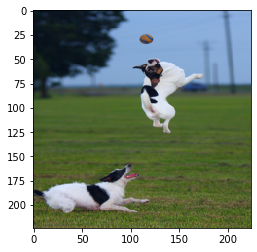

a white dogs are one black a is running over the air <end> one playing a ball <end> <end> <pad>


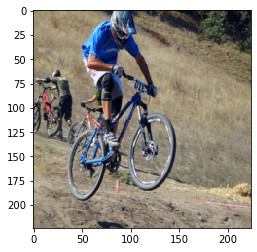

a man wearing a helmet helmet and a pants riding riding over bike over a dirt <end> <pad> red red


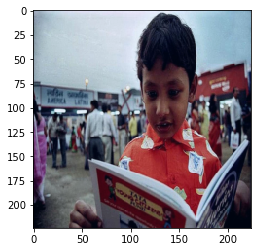

a man is a red shirt and holding in front middle <end> a a book <end> <pad> red red red


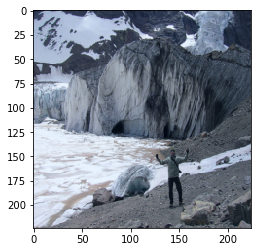

a person person is a arms the air <end> his backpack mountains <end> the background <end> <pad> red red red


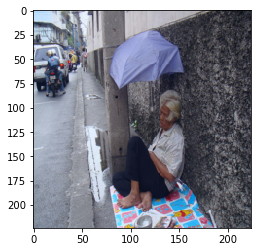

a man is wearing on a bench bench bench <end> <end> reads a cup umbrella <end> <pad> red red red


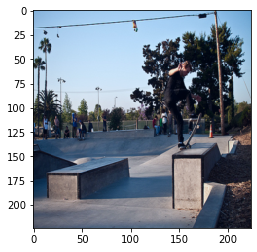

a man is jumping a bike down a ramp <end> front skate park <end> <pad> red red red red red


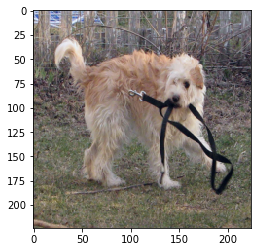

a dog dog dog dog is running through a red <end> its mouth <end> <pad> red red red red red


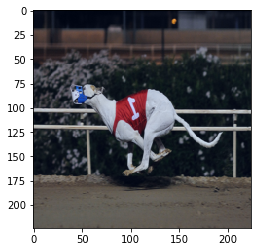

a white is a white and and a jeans is a <end> track <end> <pad> red red red red red


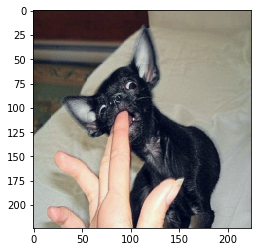

a black dog dog is a white in brown <end> a white carpet <end> <pad> red red red red red


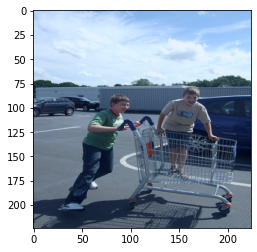

a people children are on a fountain cart <end> a park lot <end> <pad> red red red red red red


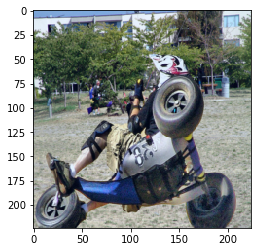

a is in jumping a skateboard wheeled scooter <end> <end> a jumping <end> <pad> red red red red red red


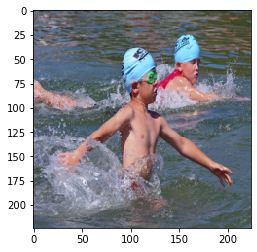

a young are life life and trunks and <end> a pool <end> <pad> red red red red red red red


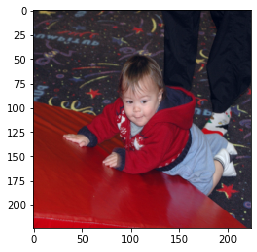

a little girl is a slide slide <end> a playground day <end> <pad> red red red red red red red


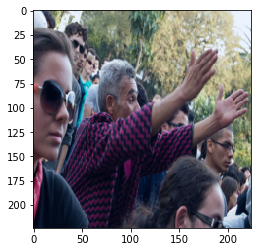

a man and his head up a a crowd of people <end> <pad> red red red red red red red


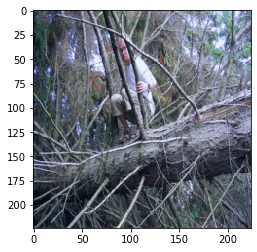

a man is on a middle of of a tree tree <end> <pad> red red red red red red red


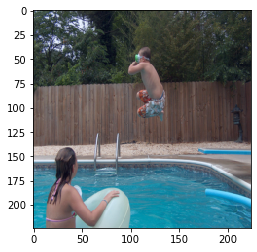

a young in into a pool <end> another boy watches <end> <pad> red red red red red red red red


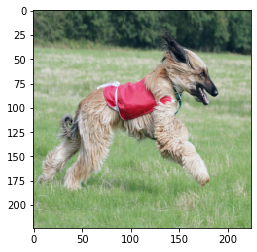

a black is the grass collar is through the grass <end> <pad> red red red red red red red red


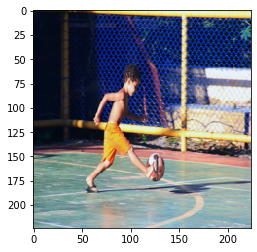

a boy in a ball ball <end> a field court <end> <pad> red red red red red red red red


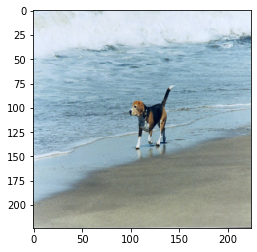

a black runs through the beach <end> to a water <end> <pad> red red red red red red red red


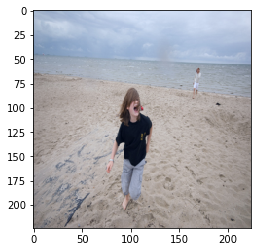

a man girl is through a beach <end> the beach <end> <pad> red red red red red red red red


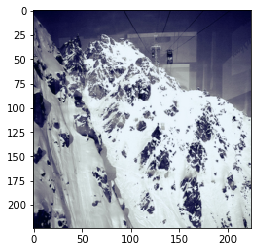

a man climber is in in his <end> a <end> <pad> red red red red red red red red red


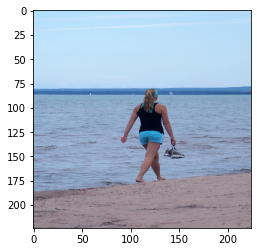

a in black shorts and on on the beach <end> <pad> red red red red red red red red red


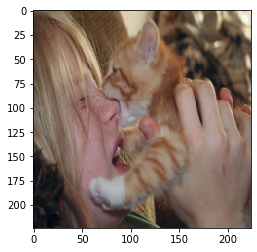

a small dog is a ear of a brown <end> <pad> red red red red red red red red red


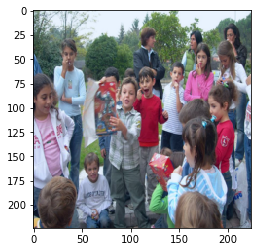

a man in a people <end> hands on in <end> <pad> red red red red red red red red red


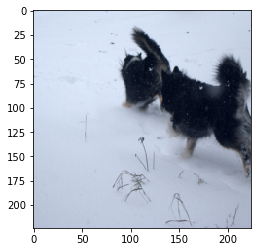

a dogs dogs dogs are through a snow <end> <pad> red red red red red red red red red red


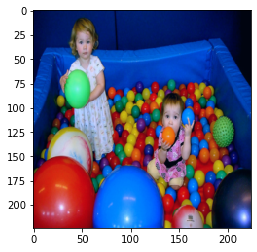

a playing in a fountain <end> water balls <end> <pad> red red red red red red red red red red


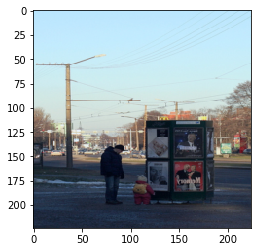

a man in a woman are at a <end> <pad> red red red red red red red red red red


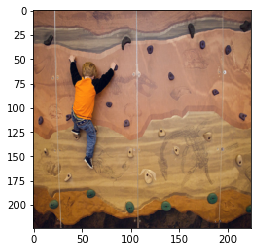

a man boy wearing a a rock <end> <end> <pad> red red red red red red red red red red


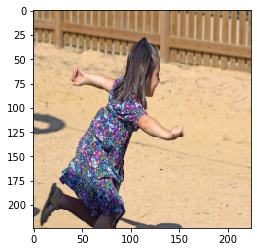

a little girl is playing on the leg <end> <pad> red red red red red red red red red red


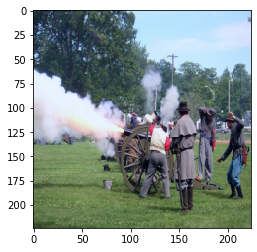

a people are in a line race reenactment <end> <pad> red red red red red red red red red red


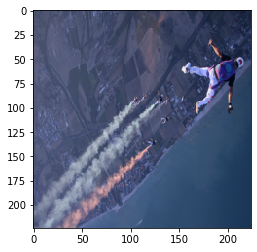

a are a on <pad> red red red red red red red red red red red red red red red


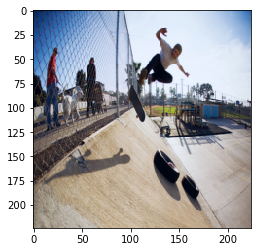

a man is off <pad> red red red red red red red red red red red red red red red


In [53]:
for i, s in enumerate(sentences):
    show(make_grid(images[i], normalize=True))
    print(s)